In [10]:
import torch
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt
from escnn import nn, group, gspaces

import sys

sys.path.append("..")

from models.core.point_convolution import ImplicitPointConv
from utils.nonlinearities import get_elu

In this example, we will create a simple rotation-equivariant classifier that employs point convolution layers. As always, we start by defining the group and the space it acts on.

In [11]:
g = "o3"

In [12]:
if g == "o3":
    gspace = gspaces.flipRot3dOnR3()
elif g == "so3":
    gspace = gspaces.rot3dOnR3()

As in the previous examples, the point cloud has the following data structure: scalar, vector and pseudoscalar. Let's assume that there are 10 classes in the dataset. It means that we need to predict a probability of each class for each data point. Probability is a scalar, hence it is associated with trivial representation. For edge attributes, we will use scalar and vector attributes (e.g. distance and surface normals).

In [13]:
scalar_repr = gspace.trivial_repr
vector_repr = gspace.fibergroup.standard_representation()
channel_repr = group.directsum([scalar_repr, vector_repr])
edge_channel_repr = group.directsum([scalar_repr, vector_repr])

In [14]:
c_in = 3
c_out = 10
c_attr = 5

in_repr = c_in * [channel_repr]
out_repr = c_out * [gspace.trivial_repr]
attr_repr = c_attr * [edge_channel_repr]

In [15]:
in_type = gspace.type(*in_repr)
out_type = gspace.type(*out_repr)
attr_type = gspace.type(*attr_repr)

Since implicit kernels are only able to work with uniform representations, in general case, we will need to linearly project our data. Let us implement such a projection operator.

In [16]:
class Projector(nn.EquivariantModule):
    def __init__(self, in_type: nn.FieldType, out_type: nn.FieldType):
        """
        A simple linear layer.

        Warning: sincle nn.Linear works on 0D base space (gspaces.no_base_space(G)),
                 we will need to temporarily move our data there, to perform the linear operation.

        Args:
            in_type (nn.FieldType): input field type
            out_type (nn.FieldType): output field type
        """
        super().__init__()
        self.in_type = in_type
        self.out_type = out_type

        gspace = gspaces.no_base_space(in_type.gspace.fibergroup)
        self.hid_type1 = gspace.type(*in_type.representations)
        self.hid_type2 = gspace.type(*out_type.representations)

        self.linear = nn.Linear(self.hid_type1, self.hid_type2)

    def forward(self, x):
        """
        Forward pass of the linear layer:
            1. Move the input to 0D base space.
            2. Apply the linear layer.
            3. Move the output back to the original base space.

        Args:
            x (nn.GeometricTensor): input feature map

        Returns:
            nn.GeometricTensor: output feature map
        """
        x, coords = x.tensor, x.coords
        x = self.hid_type1(x)
        x = self.linear(x)
        x = nn.GeometricTensor(x.tensor, self.out_type, coords)
        return x

    def evaluate_output_shape(self):
        pass

Our model will consist of a projection layer, 3 point convolutions and an output layer, with intermediate normalizations and non-linearities.

In [17]:
class Model(nn.EquivariantModule):
    def __init__(self, in_type, out_type, hidden_channels, L):
        super().__init__()

        self.activation = get_elu(gspace=gspace, L=L, channels=hidden_channels)
        hidden_type = self.activation.out_type

        self.proj_in = Projector(in_type, hidden_type)

        self.bnorm1 = nn.IIDBatchNorm1d(hidden_type)

        self.layer1 = ImplicitPointConv(
            in_type=hidden_type,
            out_type=hidden_type,
            edge_attr_type=attr_type,
            n_layers=1,
            n_channels=8,
        )

        self.bnorm2 = nn.IIDBatchNorm1d(hidden_type)
        self.layer2 = ImplicitPointConv(
            in_type=hidden_type,
            out_type=hidden_type,
            edge_attr_type=attr_type,
            n_layers=3,
            n_channels=8,
        )

        self.bnorm3 = nn.IIDBatchNorm1d(hidden_type)
        self.layer3 = ImplicitPointConv(
            in_type=hidden_type,
            out_type=hidden_type,
            edge_attr_type=attr_type,
            n_layers=3,
            n_channels=8,
        )

        self.bnorm_out = nn.IIDBatchNorm1d(hidden_type)
        self.proj_out = Projector(hidden_type, out_type)

    def forward(self, x, edge_index, edge_delta, edge_attr, with_activation=True):
        x = self.proj_in(x)
        x = self.activation(x)

        x = self.bnorm1(x)
        x = self.layer1(x, edge_index, edge_delta, edge_attr)
        x = self.activation(x)

        x = self.bnorm2(x)
        x = self.layer2(x, edge_index, edge_delta, edge_attr)
        x = self.activation(x)

        x = self.bnorm3(x)
        x = self.layer3(x, edge_index, edge_delta, edge_attr)
        x = self.activation(x)

        x = self.bnorm_out(x)
        x = self.proj_out(x)
        return x

    def evaluate_output_shape(self):
        pass

Initialization might take a while due to MLPs and activations initialization in each convolution.

In [18]:
model = Model(
    in_type=in_type,
    out_type=out_type,
    hidden_channels=16,
    L=1,
)

Let us now create a random input and run the model on it.

In [19]:
n_points = 100
pos = torch.randn(n_points, gspace.dimensionality)

x = nn.GeometricTensor(torch.randn(n_points, in_type.size), in_type, pos)

edge_index = torch_geometric.nn.pool.knn_graph(pos, k=32, batch=None, loop=True)
edge_delta = pos[edge_index[1]] - pos[edge_index[0]]

edge_attr = torch.randn(edge_index.size(1), c_attr * edge_channel_repr.size)

In [20]:
y = model(x, edge_index, edge_delta, edge_attr)

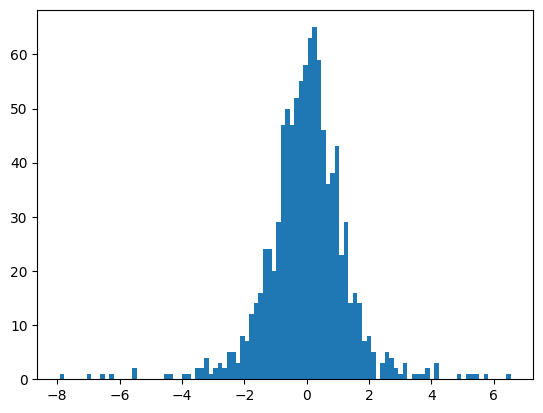

In [21]:
plt.hist(y.tensor.detach().numpy().reshape(-1)[:1000], bins=100)
plt.show()

# Test equivariance

We need to specify the type of edge features for the layer (it is done automatically inside the implicit kernel)

In [22]:
edge_attr_type = gspace.type(*attr_repr)
edge_attr_gt = edge_attr_type(edge_attr, edge_delta)

edge_delta_type = gspace.type(*[vector_repr])
edge_delta_gt = edge_delta_type(edge_delta, edge_delta)

In [23]:
errors = []

for el in list(gspace.testing_elements)[::10]:
    out1 = (
        model(
            x=x,
            edge_index=edge_index,
            edge_delta=edge_delta,
            edge_attr=edge_attr,
            with_activation=False,
        )
        .transform(el)
        .tensor.detach()
        .numpy()
    )

    out2 = (
        model(
            x.transform(el),
            edge_index=edge_index,
            edge_delta=edge_delta_gt.transform(el).tensor,
            edge_attr=edge_attr_gt.transform(el).tensor,
            with_activation=False,
        )
        .tensor.detach()
        .numpy()
    )

    errs = np.abs(out1 - out2) / (np.abs(out1) + np.abs(out2) + 1e-9)
    errors.append(errs.mean())

print(f"Average absolute error for the layer: {np.mean(errors):.2e}")

Average absolute error for the layer: 1.39e-06
